In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.circuit.library.standard_gates import XGate
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [2]:
import warnings
import contextlib

import requests
from urllib3.exceptions import InsecureRequestWarning

old_merge_environment_settings = requests.Session.merge_environment_settings

@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass

In [3]:
# Your token can be found here: https://quantum-computing.ibm.com/
API_TOKEN = "?"

In [4]:
# Save account credentials locally in $HOME/.qiskit/qiskit-ibm.json (you'll need to run this only once!). 
# IBMProvider.save_account(token=API_TOKEN, overwrite=True)

In [5]:
# Load a previously saved account and optionally select a 
# different hub/group/project in case you have access
with no_ssl_verification():
    provider = IBMProvider(instance="ibm-q/open/main")

In [6]:
# Create a quantum circuit
cr = ClassicalRegister(5)
qr = QuantumRegister(5)
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.id(qr[1])
qc.h(qr[2])
qc.id(qr[3])
qc.t(qr[4])

qc.append(XGate().control(num_ctrl_qubits=1, ctrl_state='1'), [qr[0], qr[1]])
qc.append(XGate().control(num_ctrl_qubits=1, ctrl_state='1'), [qr[2], qr[3]])

# Circuit optimizations, if any, are 
# not applied beyond the barrier
qc.barrier()

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)
qc.measure(3, 3)
qc.measure(4, 4)

# Visualize the quantum circuit
qc.draw()

┌───┐      ░ ┌─┐            
q0_0: ┤ H ├──■───░─┤M├────────────
      ├───┤┌─┴─┐ ░ └╥┘┌─┐         
q0_1: ┤ I ├┤ X ├─░──╫─┤M├─────────
      ├───┤└───┘ ░  ║ └╥┘┌─┐      
q0_2: ┤ H ├──■───░──╫──╫─┤M├──────
      ├───┤┌─┴─┐ ░  ║  ║ └╥┘┌─┐   
q0_3: ┤ I ├┤ X ├─░──╫──╫──╫─┤M├───
      ├───┤└───┘ ░  ║  ║  ║ └╥┘┌─┐
q0_4: ┤ T ├──────░──╫──╫──╫──╫─┤M├
      └───┘      ░  ║  ║  ║  ║ └╥┘
c0: 5/══════════════╩══╩══╩══╩══╩═
                    0  1  2  3  4

In [7]:
with no_ssl_verification():
    # Select quantum device to run on. Select simulator -> True if you want to run on a simulator which is faster
    # INSPECT DEVICES YOU HAVE ACCESS TO HERE: https://quantum-computing.ibm.com/services/resources?tab=yours
    backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= (len(qc.qubits)) \
        and (x.configuration().simulator == True) and (x.status().operational))
    backend = least_busy(backends)
    print("Selected the least busy backend: ", backend.name)

Selected the least busy backend:  simulator_mps


In [8]:
# Due to a bug in current version of Qiskit, not all simulators can be used here
# In case you want to use a simulator, instead of a real device, UNCOMMENT NEXT LINE
with no_ssl_verification():
    backend = provider.get_backend("ibmq_qasm_simulator")

In [9]:
# Transpile circuit and send it to a quantum device or to a simulator
# INSPECT YOUR JOBS HERE: https://quantum-computing.ibm.com/jobs
with no_ssl_verification():
    try:
        transpiled_circuit = transpile(qc, backend=backend, optimization_level=2)
        job = execute(transpiled_circuit, backend, shots=100)
        print(job)
    except Exception as ex:
        print(ex.message)

<IBMCircuitJob('ckrqa56qk5t7uvralna0')>


In [10]:
# Monitor live the job progress
with no_ssl_verification():
    job_monitor(job, interval=3)

Job Status: job has successfully run


In [12]:
# Print job results
with no_ssl_verification():
    results = job.result()
    counts = results.get_counts(transpiled_circuit)
    print("\nTotal counts are:", counts)


Total counts are: {'01111': 19, '00000': 27, '00011': 27, '01100': 27}


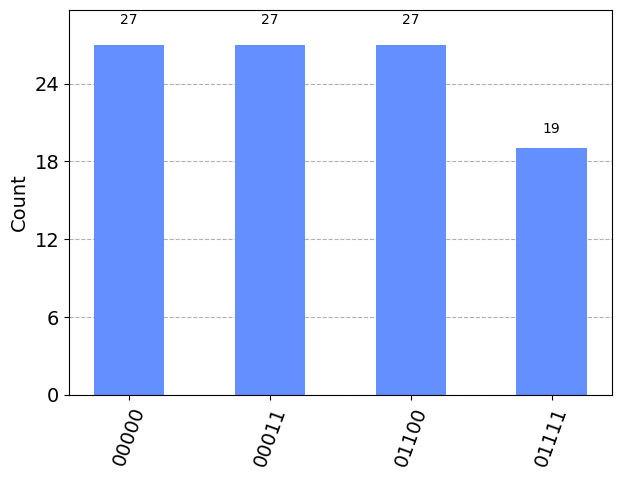

In [13]:
# Plot job results
answer = results.get_counts()
plot_histogram(answer)

In [95]:
from qiskit.tools.jupyter import *

%qiskit_version_table